#  Store Item Sales Forecasting
##### Using Machine Learning to predict sales


##### Step 0: Installation and Imports

We import libraries to access pre-written code built by other developers. This code can be used to add functionality to our own programs without having to write it all from scratch. Examples of libraries include math libraries, image processing libraries, and web application frameworks.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pyspark

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from pyspark.sql import SparkSession


color_pallet = sns.color_palette()
plt.style.use('fivethirtyeight')

StatementMeta(, f8fd4b27-37cb-4707-884a-c57de3a80b96, 3, Finished, Available, Finished)

##### Step 1: Load Store Sales Data From Silver Layer To Dataframe

In [ ]:
spark_df = spark.sql("SELECT * FROM #LAKEHOUSE_SILVER#.fact_store_sales_data")
df = spark_df.toPandas()
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df.head()

StatementMeta(, f8fd4b27-37cb-4707-884a-c57de3a80b96, 4, Finished, Available, Finished)

,date,store,item,sales
0,2018-01-01,1,1,13
1,2018-02-01,1,1,11
2,2018-03-01,1,1,14
3,2018-04-01,1,1,13
4,2018-05-01,1,1,10


##### Step 2: Exploratory Data Analysis

Exploratory Data Analysis (EDA) examines and explores a given data set to uncover patterns, draw conclusions, and identify meaningful insights. This process requires analyzing the data to summarize and visualize it in such a way that the data can be better understood. 

EDA is an important part of the process, as it helps to identify the underlying structure of the data and provides insights into any trends or relationships that may exist. Also EDA helps to identify important features of the data and to identify areas of further inquiry.


In [3]:
df.tail(5)

StatementMeta(, f8fd4b27-37cb-4707-884a-c57de3a80b96, 5, Finished, Available, Finished)

,date,store,item,sales
912995,NaT,10,50,63
912996,NaT,10,50,59
912997,NaT,10,50,74
912998,NaT,10,50,62
912999,NaT,10,50,82


###### Checking description of data frame

In [4]:
df.describe()

StatementMeta(, f8fd4b27-37cb-4707-884a-c57de3a80b96, 6, Finished, Available, Finished)

,date,store,item,sales
count,360500,913000.000000,913000.000000,913000.000000
mean,2020-06-21 20:06:19.472954112,5.500000,25.500000,52.250287
min,2018-01-01 00:00:00,1.000000,1.000000,0.000000
25%,2019-04-01 00:00:00,3.000000,13.000000,30.000000
50%,2020-07-01 00:00:00,5.500000,25.500000,47.000000
75%,2021-09-12 00:00:00,8.000000,38.000000,70.000000
max,2022-12-12 00:00:00,10.000000,50.000000,231.000000
std,NaN,2.872283,14.430878,28.801144


###### Checking shape of the dataframe

In [5]:
df.shape

StatementMeta(, f8fd4b27-37cb-4707-884a-c57de3a80b96, 7, Finished, Available, Finished)

(913000, 4)

###### Checking datatype of columns

In [6]:
df.dtypes

StatementMeta(, f8fd4b27-37cb-4707-884a-c57de3a80b96, 8, Finished, Available, Finished)

date     datetime64[ns]
store             int32
item              int32
sales             int32
dtype: object

###### Checking unique values in date column

In [7]:
f'Total dates: {df[["date"]].nunique()[0]}'

StatementMeta(, f8fd4b27-37cb-4707-884a-c57de3a80b96, 9, Finished, Available, Finished)

/tmp/ipykernel_5703/2505846462.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f'Total dates: {df[["date"]].nunique()[0]}'


'Total dates: 720'

###### Checking unique values in store column

In [8]:
f'Total store: {df[["store"]].nunique()[0]}'

StatementMeta(, f8fd4b27-37cb-4707-884a-c57de3a80b96, 10, Finished, Available, Finished)

/tmp/ipykernel_5703/3915488637.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f'Total store: {df[["store"]].nunique()[0]}'


'Total store: 10'

###### Checking unique values in item column

In [9]:
f'Total items: {df[["item"]].nunique()[0]}'

StatementMeta(, f8fd4b27-37cb-4707-884a-c57de3a80b96, 11, Finished, Available, Finished)

/tmp/ipykernel_5703/190650879.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f'Total items: {df[["item"]].nunique()[0]}'


'Total items: 50'

###### Checking null data

In [10]:
df[df.isna().any(axis=1) | df.isnull().any(axis=1)]

StatementMeta(, f8fd4b27-37cb-4707-884a-c57de3a80b96, 12, Finished, Available, Finished)

,date,store,item,sales
12,NaT,1,1,10
13,NaT,1,1,12
14,NaT,1,1,5
15,NaT,1,1,7
16,NaT,1,1,16
...,...,...,...,...
912995,NaT,10,50,63
912996,NaT,10,50,59
912997,NaT,10,50,74
912998,NaT,10,50,62


Since we used the dataset from Kaggle competition, it looks like we have a clean data ready to create Model.

##### Step 3: Grouping sales of all store by date

In [11]:
df = df.groupby('date').sum('sales')
df.index = pd.to_datetime(df.index)
df = df.drop(['store','item'], axis=1)
df.head()

StatementMeta(, f8fd4b27-37cb-4707-884a-c57de3a80b96, 13, Finished, Available, Finished)

,sales
date,
2018-01-01,13696
2018-01-02,17473
2018-01-03,20978
2018-01-04,18204
2018-01-05,22967


StatementMeta(, f8fd4b27-37cb-4707-884a-c57de3a80b96, 14, Finished, Available, Finished)

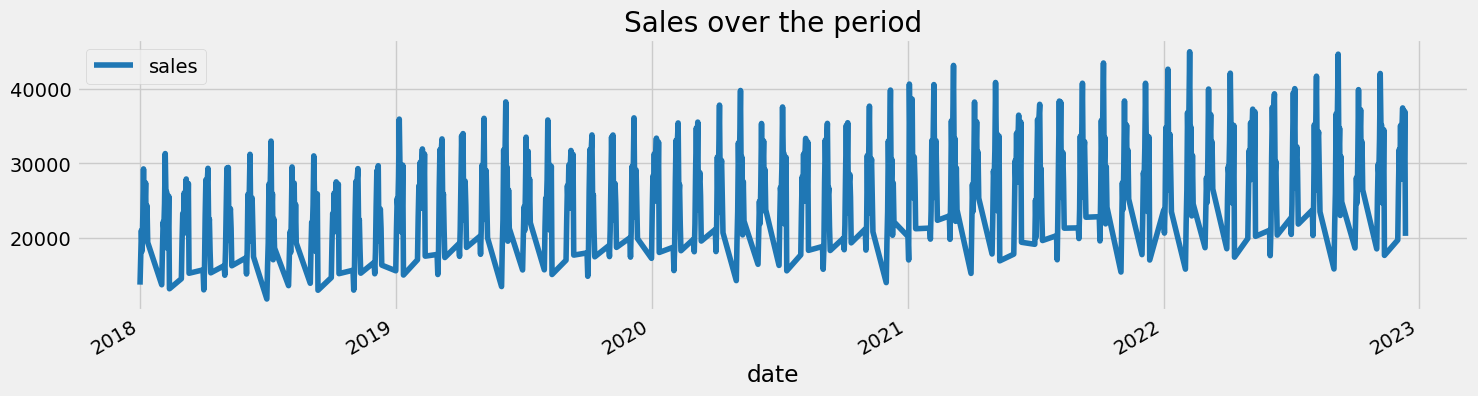

In [12]:
df.plot(
        # style='.',
        figsize=(16, 4),
        color=color_pallet[0],
        title='Sales over the period')
plt.show()

##### Step 4: Train and Test Split
Splitting the data into training and testing datasets allows us to evaluate how well the model generalizes to unseen data. The training dataset is used to build the model, while the test dataset is used to evaluate how well the model performs on unseen data. 

Here we are splitting the data with train data as before date '01-01-2022' & test data as on and after date '01-01-2022'

StatementMeta(, f8fd4b27-37cb-4707-884a-c57de3a80b96, 15, Finished, Available, Finished)

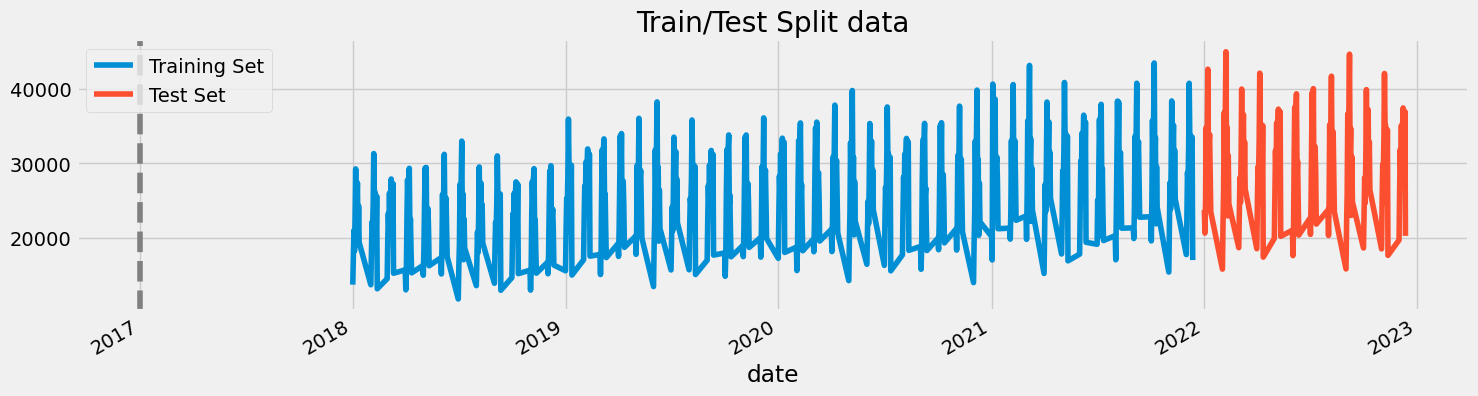

In [13]:
train = df.loc[df.index < '01-01-2022']
test = df.loc[df.index >= '01-01-2022']

fig, ax = plt.subplots(figsize=(16, 4))
train.plot(ax=ax, label='Training Set', title='Train/Test Split data')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2017', color='Gray', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

###### Weekly Sales for first week of january 2018

StatementMeta(, f8fd4b27-37cb-4707-884a-c57de3a80b96, 16, Finished, Available, Finished)

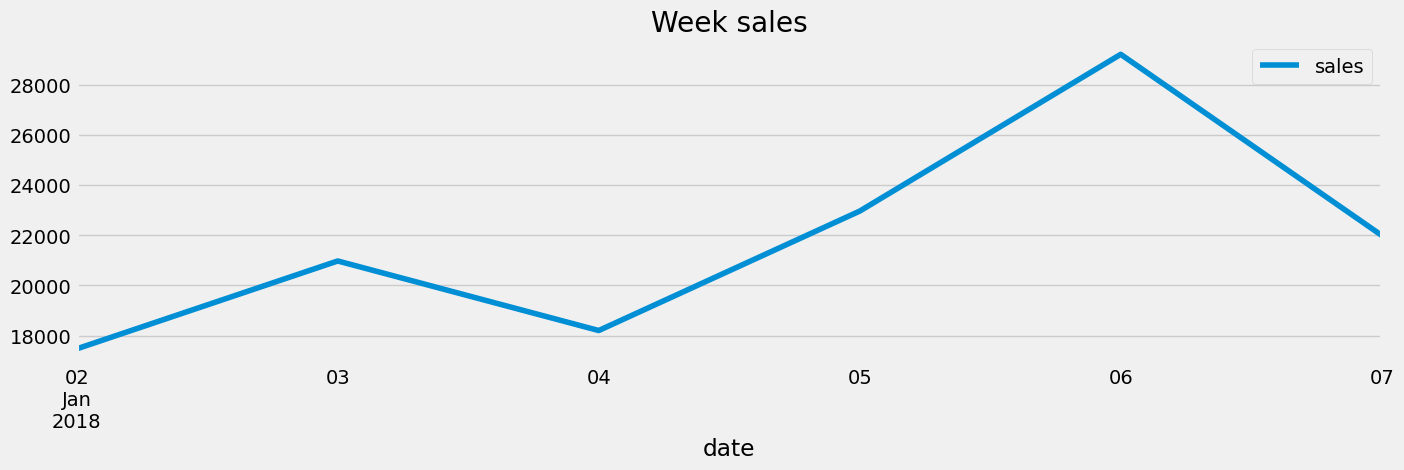

In [14]:
df.loc[(df.index > '01-01-2018') & (df.index < '01-08-2018')] \
    .plot(figsize=(15, 4), title='Week sales')
plt.show()

###### Monthly Sales for first month of january 2018

StatementMeta(, f8fd4b27-37cb-4707-884a-c57de3a80b96, 17, Finished, Available, Finished)

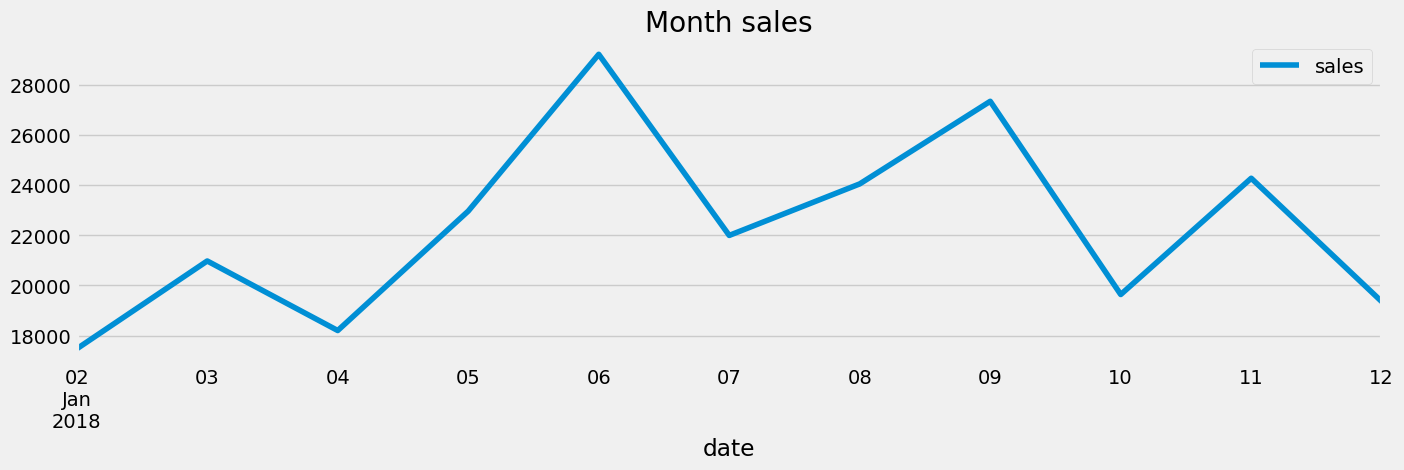

In [15]:
df.loc[(df.index > '01-01-2018') & (df.index < '01-31-2018')] \
    .plot(figsize=(15, 4), title='Month sales')
plt.show()

##### Step 4: Feature engineering
Feature engineering is the process of transforming raw data into meaningful features that enhance the performance of machine learning models. It involves selecting, creating, and modifying features to extract relevant information, reduce noise, and improve the predictive power of the model.

In [16]:
def create_features(df):
    """
    Creating time series features based on dataframe index.
    """
    df = df.copy()
    # df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

StatementMeta(, f8fd4b27-37cb-4707-884a-c57de3a80b96, 18, Finished, Available, Finished)

#### Step 5: Visualizing feature and target Relationship
Visualizing the relationship between features and the target variable helps to understand the correlation, patterns, and trends in the data. It provides insights into how different features impact the target variable and helps in identifying important predictors for the model.

StatementMeta(, f8fd4b27-37cb-4707-884a-c57de3a80b96, 19, Finished, Available, Finished)

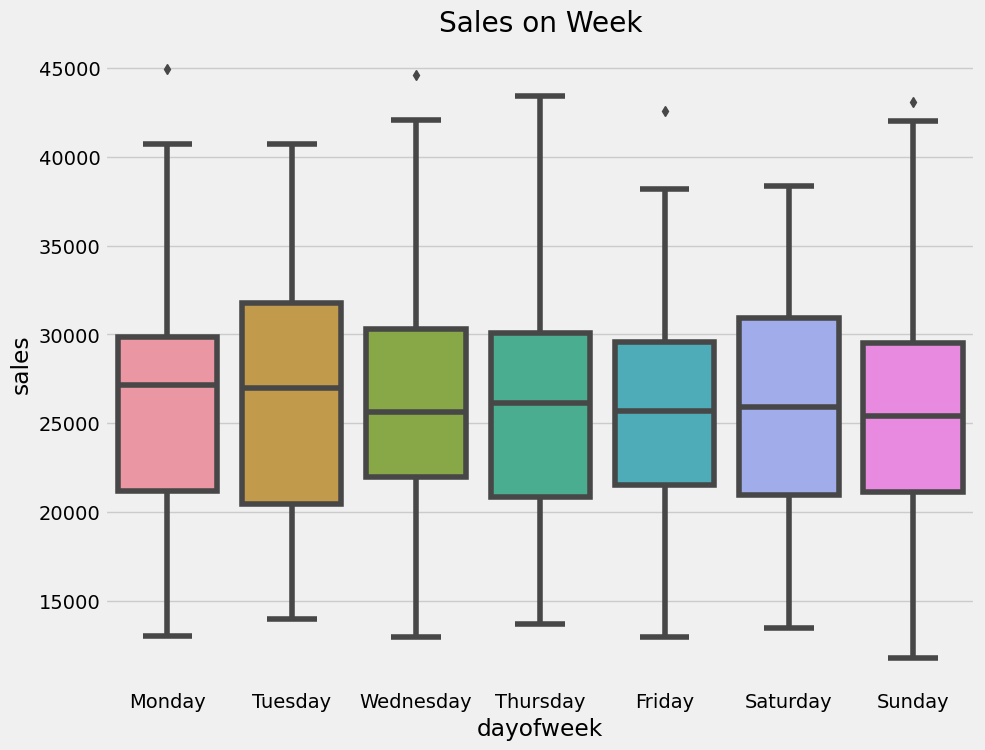

In [17]:
week_day_map = {
    0: 'Monday',
    1: 'Tuesday',
    2: 'Wednesday',
    3: 'Thursday',
    4: 'Friday',
    5: 'Saturday',
    6: 'Sunday',
}
df_temp = df.copy()
df_temp['dayofweek'] = df_temp['dayofweek'].map(lambda index: week_day_map[index])

fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df_temp, x='dayofweek', y='sales')
ax.set_title('Sales on Week')
plt.show()

StatementMeta(, f8fd4b27-37cb-4707-884a-c57de3a80b96, 20, Finished, Available, Finished)

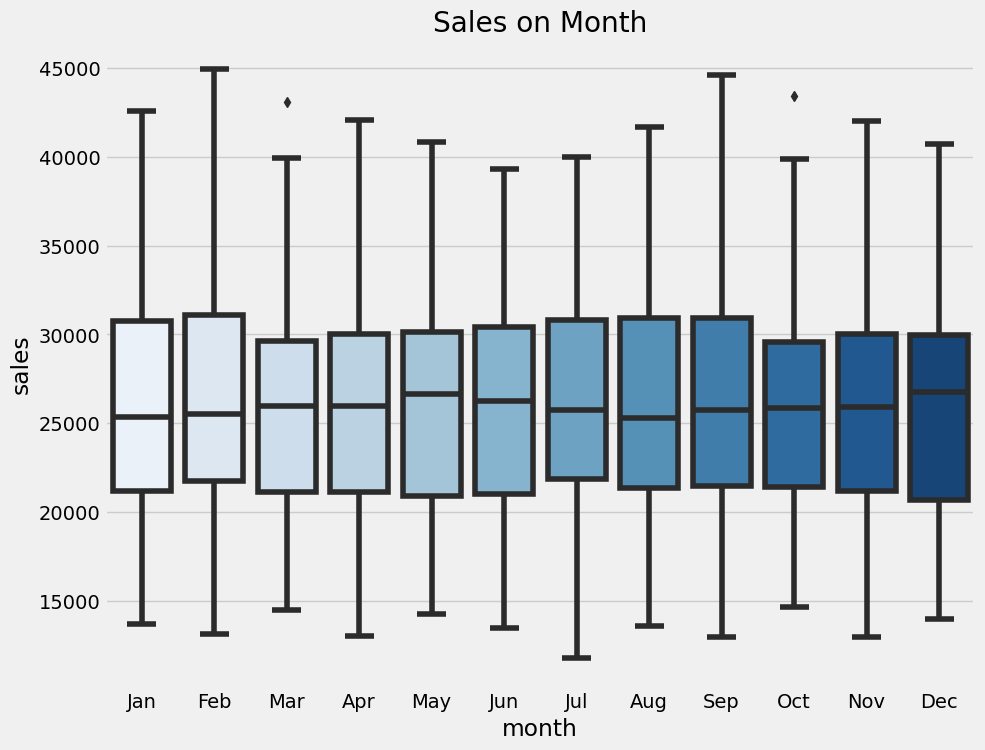

In [18]:
month_map = {
    1: 'Jan',
    2: 'Feb',
    3: 'Mar',
    4: 'Apr',
    5: 'May',
    6: 'Jun',
    7: 'Jul',
    8: 'Aug',
    9: 'Sep',
    10: 'Oct',
    11: 'Nov',
    12: 'Dec',
}
df_temp = df.copy()
df_temp['month'] = df_temp['month'].map(lambda index: month_map[index])

fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df_temp, x='month', y='sales', palette='Blues')
ax.set_title('Sales on Month')
plt.show()

StatementMeta(, f8fd4b27-37cb-4707-884a-c57de3a80b96, 21, Finished, Available, Finished)

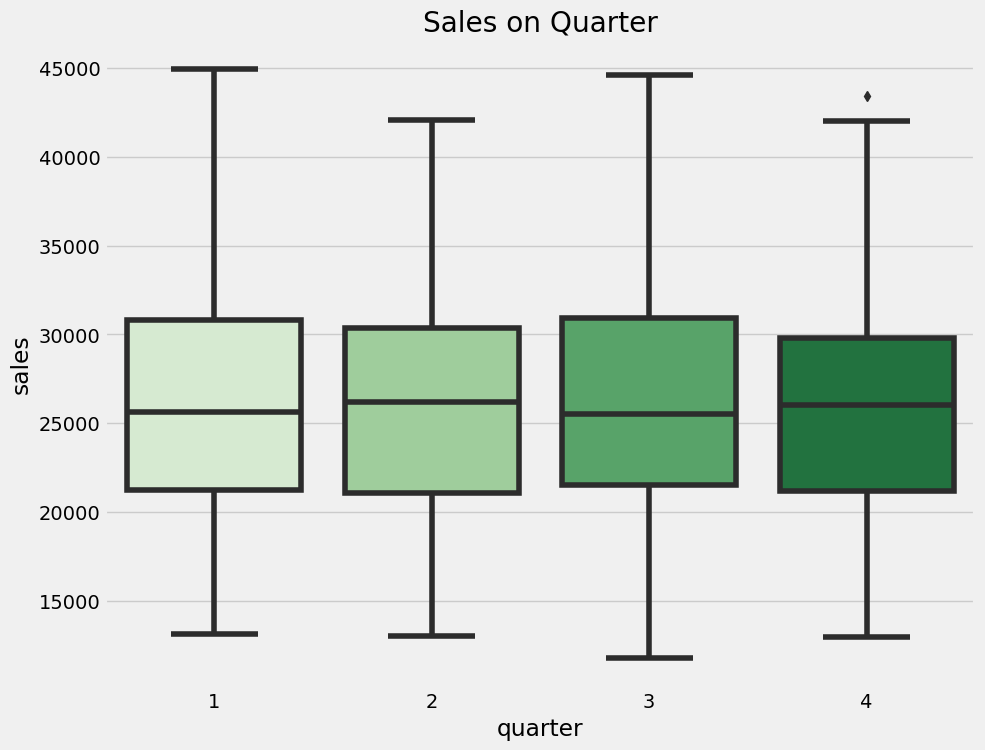

In [19]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df_temp, x='quarter', y='sales', palette='Greens')
ax.set_title('Sales on Quarter')
plt.show()

#### Step 6: Creating Model
Model creation is a process of selecting and training an algorithm using a labeled dataset to learn patterns and make predictions on new data. It is a crucial step in building predictive models and requires careful consideration of algorithm selection, parameter tuning, and evaluation to ensure accurate and reliable results.

Selecting features and target columns for Model creation

In [20]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'sales'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

StatementMeta(, f8fd4b27-37cb-4707-884a-c57de3a80b96, 22, Finished, Available, Finished)

###### Step 6.1: Linear Regression Model

In [21]:
linreg_model = LinearRegression()
linreg_model.fit(X_train, y_train)

StatementMeta(, f8fd4b27-37cb-4707-884a-c57de3a80b96, 23, Finished, Available, Finished)

LinearRegression()

StatementMeta(, f8fd4b27-37cb-4707-884a-c57de3a80b96, 24, Finished, Available, Finished)

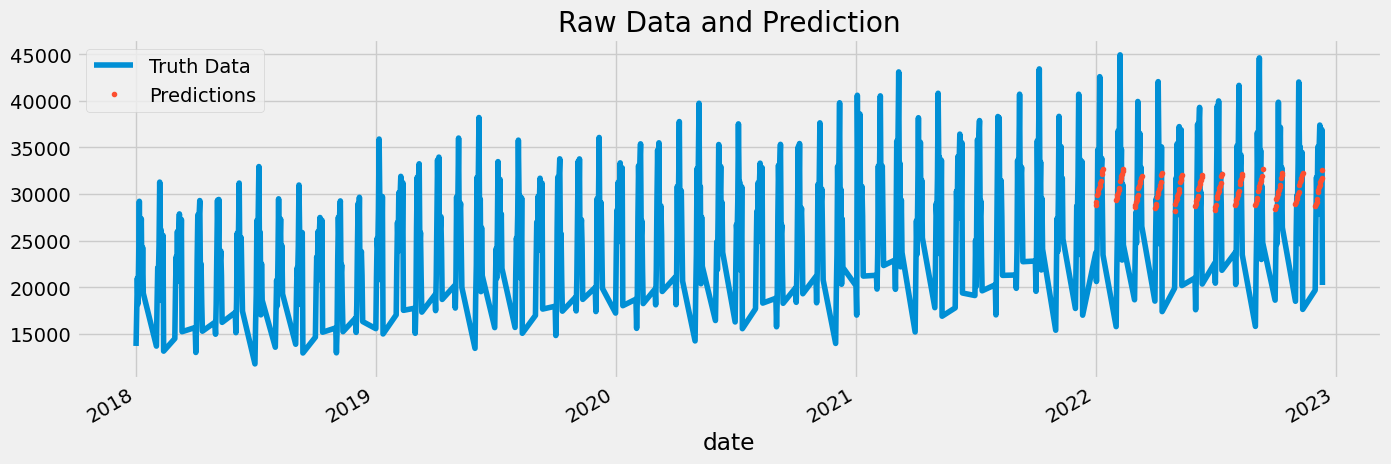

In [22]:
# test['prediction_lr'] = linreg_pred.predict(X_test)
test['prediction_lr'] = linreg_model.predict(X_test)
df = df.merge(test[['prediction_lr']], how='left', left_index=True, right_index=True)
ax = df[['sales']].plot(figsize=(15, 5))
df['prediction_lr'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

In [23]:
linreg_rmse = np.sqrt(mean_squared_error(test['sales'], test['prediction_lr']))
linreg_mae = mean_absolute_error(test['sales'], test['prediction_lr'])
linreg_r2 = r2_score(test['sales'], test['prediction_lr'])
print('Linear Regression RMSE: ', linreg_rmse)
print('Linear Regression MAE: ', linreg_mae)
print('Linear Regression R2 Score: ', linreg_r2)

StatementMeta(, f8fd4b27-37cb-4707-884a-c57de3a80b96, 25, Finished, Available, Finished)

Linear Regression RMSE:  6408.087458808965
Linear Regression MAE:  5276.575329401524
Linear Regression R2 Score:  0.02272538657862433


###### Step 6.2: Random Forest Model

In [24]:
rf_model = RandomForestRegressor(n_estimators=100, max_depth=20)
rf_model.fit(X_train, y_train)

StatementMeta(, f8fd4b27-37cb-4707-884a-c57de3a80b96, 26, Finished, Available, Finished)

RandomForestRegressor(max_depth=20)

StatementMeta(, f8fd4b27-37cb-4707-884a-c57de3a80b96, 27, Finished, Available, Finished)

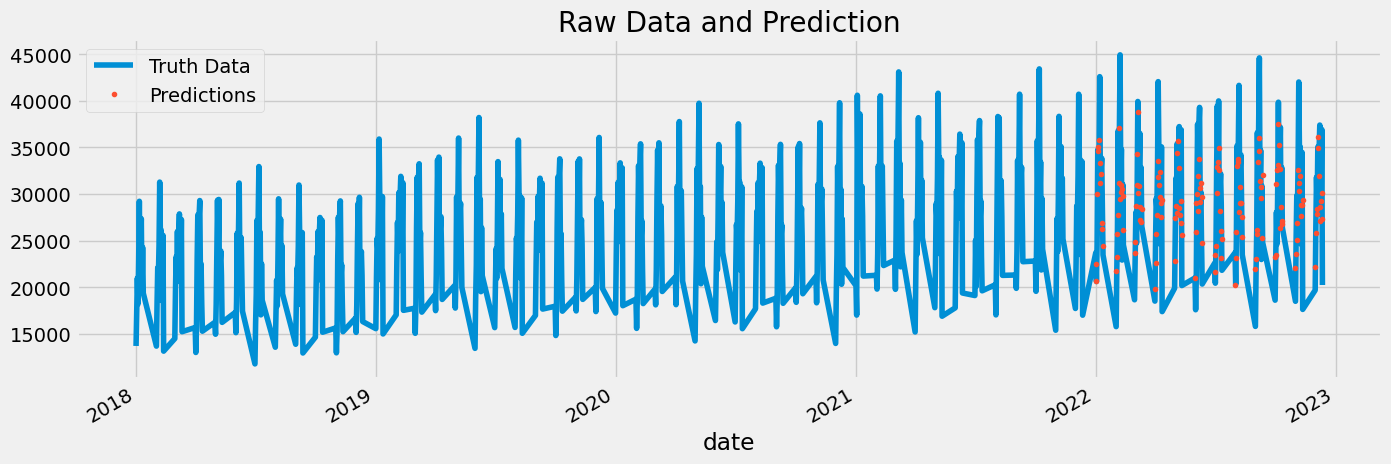

In [25]:
test['prediction_rf'] = rf_model.predict(X_test)
df = df.merge(test[['prediction_rf']], how='left', left_index=True, right_index=True)
ax = df[['sales']].plot(figsize=(15, 5))
df['prediction_rf'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

In [26]:
rf_rmse = np.sqrt(mean_squared_error(test['sales'], test['prediction_rf']))
rf_mae = mean_absolute_error(test['sales'], test['prediction_rf'])
rf_r2 = r2_score(test['sales'], test['prediction_rf'])
print('Random Forest RMSE: ', rf_rmse)
print('Random Forest MAE: ', rf_mae)
print('Random Forest R2 Score: ', rf_r2)

StatementMeta(, f8fd4b27-37cb-4707-884a-c57de3a80b96, 28, Finished, Available, Finished)

Random Forest RMSE:  5204.636172900162
Random Forest MAE:  3944.791833310786
Random Forest R2 Score:  0.3553254764167312


###### Step 6.3: XGBOOST Model

In [27]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

StatementMeta(, f8fd4b27-37cb-4707-884a-c57de3a80b96, 29, Finished, Available, Finished)

[100]	validation_0-rmse:10830.44621	validation_1-rmse:13270.40161
[200]	validation_0-rmse:6416.39385	validation_1-rmse:8113.81019
[300]	validation_0-rmse:5382.35174	validation_1-rmse:6745.91419
[400]	validation_0-rmse:5070.98985	validation_1-rmse:6333.46701
[500]	validation_0-rmse:4792.28577	validation_1-rmse:6094.67456
[600]	validation_0-rmse:4516.60240	validation_1-rmse:5894.88923
[700]	validation_0-rmse:4307.14412	validation_1-rmse:5767.92290
[800]	validation_0-rmse:4129.30122	validation_1-rmse:5644.75630
[900]	validation_0-rmse:3947.05747	validation_1-rmse:5500.07333
[999]	validation_0-rmse:3786.21988	validation_1-rmse:5372.42040


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

###### Step 6.4: Feature Importance

StatementMeta(, f8fd4b27-37cb-4707-884a-c57de3a80b96, 30, Finished, Available, Finished)

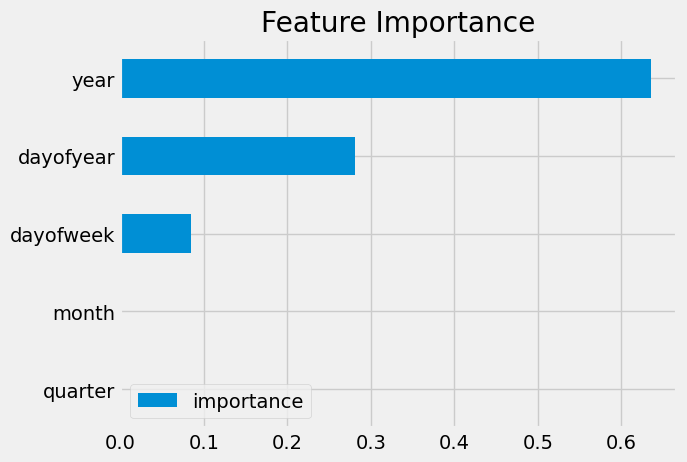

In [28]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.get_booster().feature_names,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

StatementMeta(, f8fd4b27-37cb-4707-884a-c57de3a80b96, 31, Finished, Available, Finished)

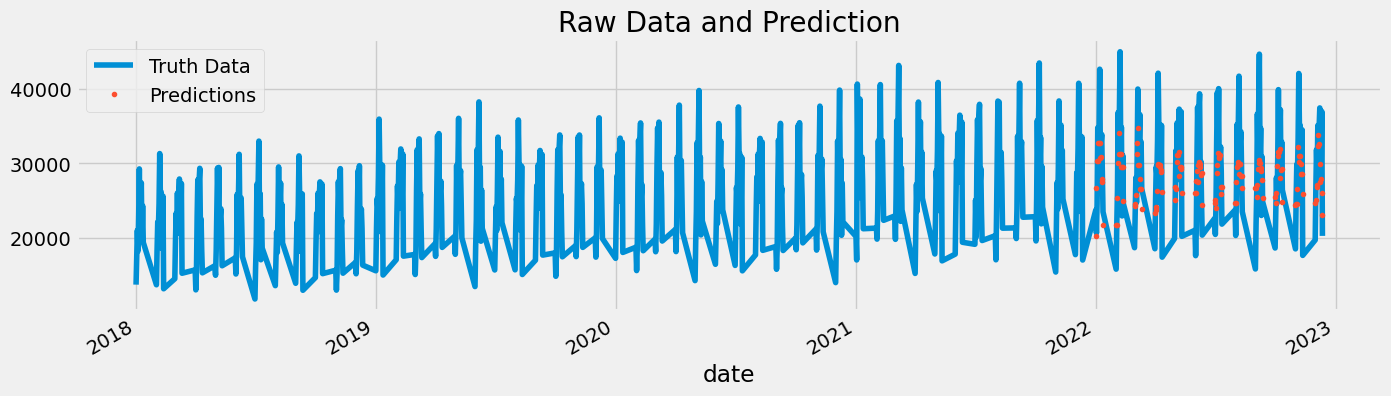

In [29]:
test['prediction_xgb'] = reg.predict(X_test)
df = df.merge(test[['prediction_xgb']], how='left', left_index=True, right_index=True)
ax = df[['sales']].plot(figsize=(15, 4))
df['prediction_xgb'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

In [30]:
# score = np.sqrt(mean_squared_error(test['sales'], test['prediction']))
# print(f'RMSE Score on Test set: {score:0.2f}')

xg_rmse = np.sqrt(mean_squared_error(test['sales'], test['prediction_xgb']))
xg_mae = mean_absolute_error(test['sales'], test['prediction_xgb'])
xg_r2 = r2_score(test['sales'], test['prediction_xgb'])
print('XGBoost RMSE: ', xg_rmse)
print('XGBoost MAE: ', xg_mae)
print('XGBoost R2 Score: ', xg_r2)

StatementMeta(, f8fd4b27-37cb-4707-884a-c57de3a80b96, 32, Finished, Available, Finished)

XGBoost RMSE:  5372.420387893766
XGBoost MAE:  4306.250339084201
XGBoost R2 Score:  0.3130901666805417


###### Step 6.5: Comparing Linear Regression, Random Forest, XG Boost

In [31]:
linreg_stats = [linreg_rmse, linreg_mae, linreg_r2]
rf_stats = [rf_rmse, rf_mae, rf_r2]
xgb_stats = [xg_rmse, xg_mae, xg_r2]

StatementMeta(, f8fd4b27-37cb-4707-884a-c57de3a80b96, 33, Finished, Available, Finished)

StatementMeta(, f8fd4b27-37cb-4707-884a-c57de3a80b96, 34, Finished, Available, Finished)

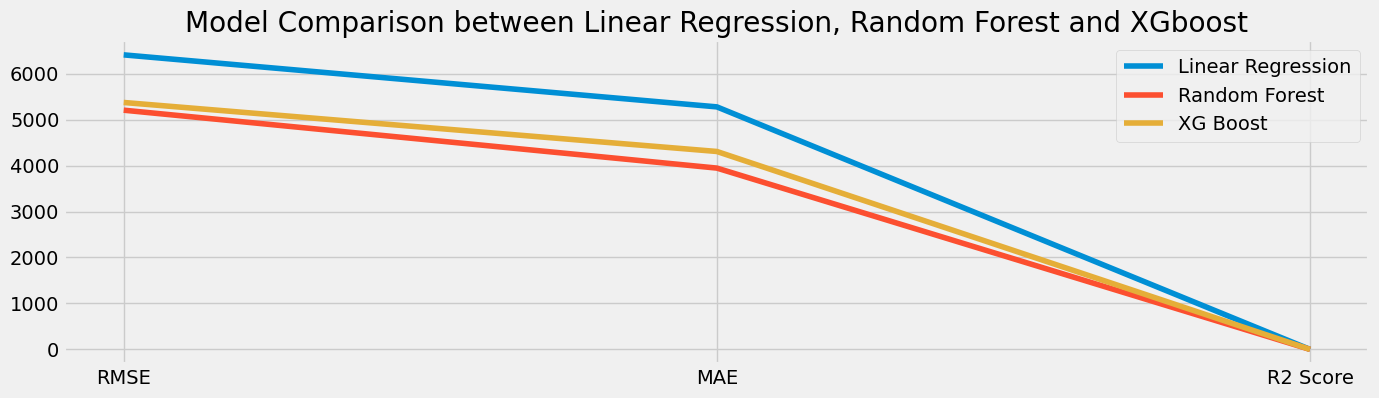

In [32]:
plt.figure(figsize=(15,4))
plt.plot(linreg_stats)
plt.plot(rf_stats)
plt.plot(xgb_stats)
plt.title("Model Comparison between Linear Regression, Random Forest and XGboost")
plt.xticks([0,1,2], labels=['RMSE','MAE','R2 Score'])
plt.legend(["Linear Regression", "Random Forest", "XG Boost"])
plt.show()

#### Step 7: Using Random Forest as best prediction

In [33]:
test['prediction'] = test['prediction_rf']
df['prediction'] = df['prediction_rf']
df

StatementMeta(, f8fd4b27-37cb-4707-884a-c57de3a80b96, 35, Finished, Available, Finished)

,sales,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,prediction_lr,prediction_rf,prediction_xgb,prediction
date,,,,,,,,,,,,
2018-01-01,13696,0,1,1,2018,1,1,1,NaN,NaN,NaN,NaN
2018-01-02,17473,1,1,1,2018,2,2,1,NaN,NaN,NaN,NaN
2018-01-03,20978,2,1,1,2018,3,3,1,NaN,NaN,NaN,NaN
2018-01-04,18204,3,1,1,2018,4,4,1,NaN,NaN,NaN,NaN
2018-01-05,22967,4,1,1,2018,5,5,1,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-08,37400,3,4,12,2022,342,8,49,30991.556299,28575.890,29938.847656,28575.890
2022-12-09,28537,4,4,12,2022,343,9,49,31250.368686,27052.986,27450.015625,27052.986
2022-12-10,28540,5,4,12,2022,344,10,49,31509.181073,29231.981,27816.867188,29231.981


#### Calculate Error
Look at the worst and best predicted days

In [34]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['dates'] = test.index.date

StatementMeta(, f8fd4b27-37cb-4707-884a-c57de3a80b96, 36, Finished, Available, Finished)

In [35]:
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

StatementMeta(, f8fd4b27-37cb-4707-884a-c57de3a80b96, 37, Finished, Available, Finished)

date
2022-02-07    15467.482222
2022-08-07    13627.194000
2022-04-12    11970.786458
2022-11-12    11739.310000
2022-11-06    11653.450000
2022-10-09    10768.851429
2022-09-04    10447.030000
2022-04-06    10219.275758
2022-09-07    10031.815000
2022-05-11    10018.644091
Name: error, dtype: float64

#### Step 8: Lets Predict on Future

StatementMeta(, f8fd4b27-37cb-4707-884a-c57de3a80b96, 38, Finished, Available, Finished)

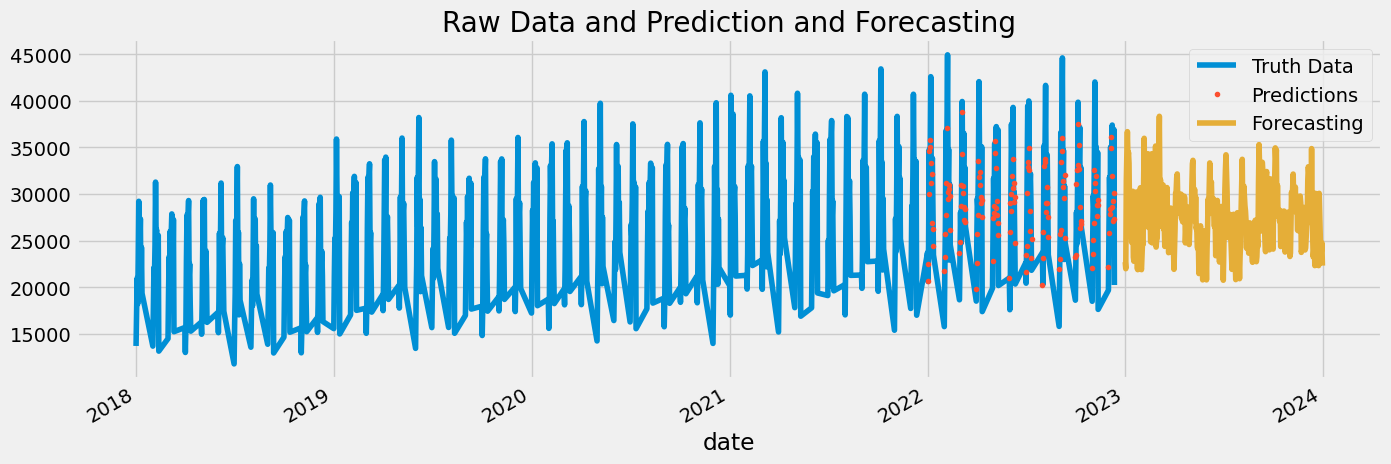

In [36]:
# One Year forecasting
to_predict = pd.DataFrame(pd.date_range(start="2023-01-01", end="2023-12-31"), columns=['date'])
to_predict.index = pd.to_datetime(to_predict.date)

to_predict_feature = create_features(to_predict)
to_predict_feature = to_predict_feature[FEATURES]

to_predict_feature['prediction'] = rf_model.predict(to_predict_feature)
ax = df[['sales']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
to_predict_feature['prediction'].plot(ax=ax)
plt.legend(['Truth Data', 'Predictions', 'Forecasting'])
ax.set_title('Raw Data and Prediction and Forecasting')
plt.show()

StatementMeta(, f8fd4b27-37cb-4707-884a-c57de3a80b96, 39, Finished, Available, Finished)

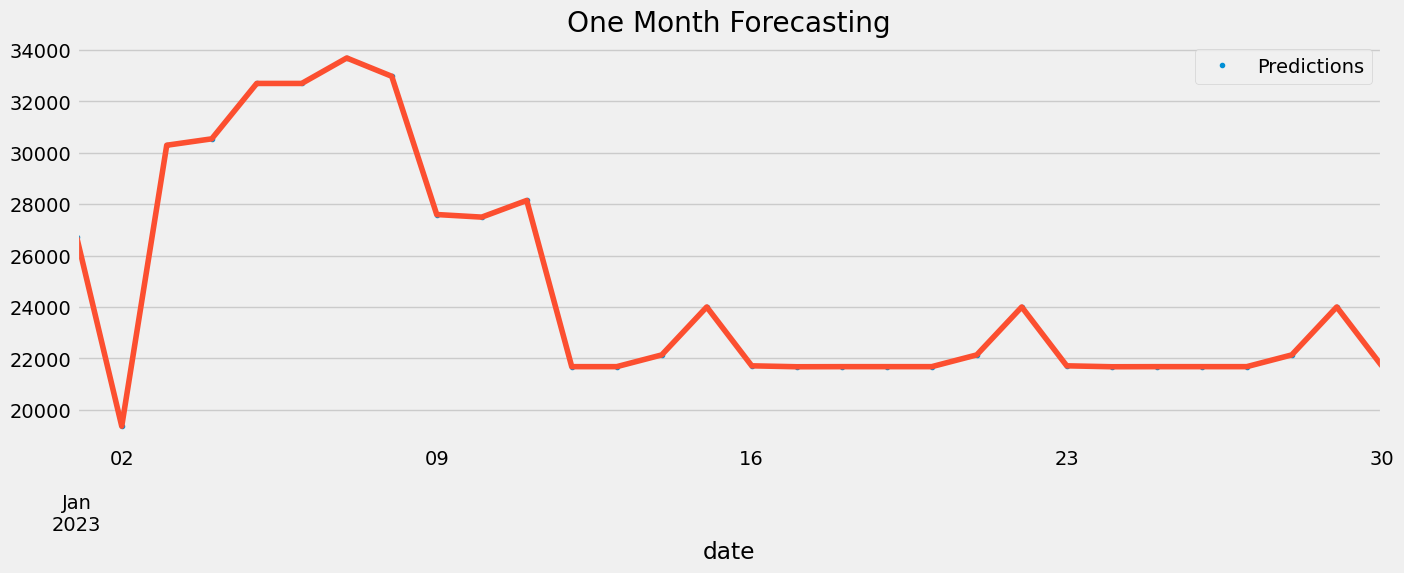

In [37]:
# One Month Forecasting
to_predict = pd.DataFrame(pd.date_range(start="2023-01-01", end="2023-01-30"), columns=['date'])
to_predict.index = pd.to_datetime(to_predict.date)

to_predict_feature = create_features(to_predict)
to_predict_feature = to_predict_feature[FEATURES]

to_predict_feature['prediction'] = reg.predict(to_predict_feature)
ax = to_predict_feature['prediction'].plot(figsize=(15, 5), style='.')
to_predict_feature['prediction'].plot(ax=ax)
plt.legend(['Predictions'])
ax.set_title('One Month Forecasting')
plt.show()

In [38]:
# One Month forecasting 
to_predict_feature

StatementMeta(, f8fd4b27-37cb-4707-884a-c57de3a80b96, 40, Finished, Available, Finished)

,dayofyear,dayofweek,quarter,month,year,prediction
date,,,,,,
2023-01-01,1,6,1,1,2023,26711.046875
2023-01-02,2,0,1,1,2023,19361.431641
2023-01-03,3,1,1,1,2023,30295.265625
2023-01-04,4,2,1,1,2023,30544.326172
2023-01-05,5,3,1,1,2023,32700.326172
2023-01-06,6,4,1,1,2023,32700.326172
2023-01-07,7,5,1,1,2023,33690.871094
2023-01-08,8,6,1,1,2023,32979.003906
2023-01-09,9,0,1,1,2023,27598.484375


StatementMeta(, f8fd4b27-37cb-4707-884a-c57de3a80b96, 41, Finished, Available, Finished)

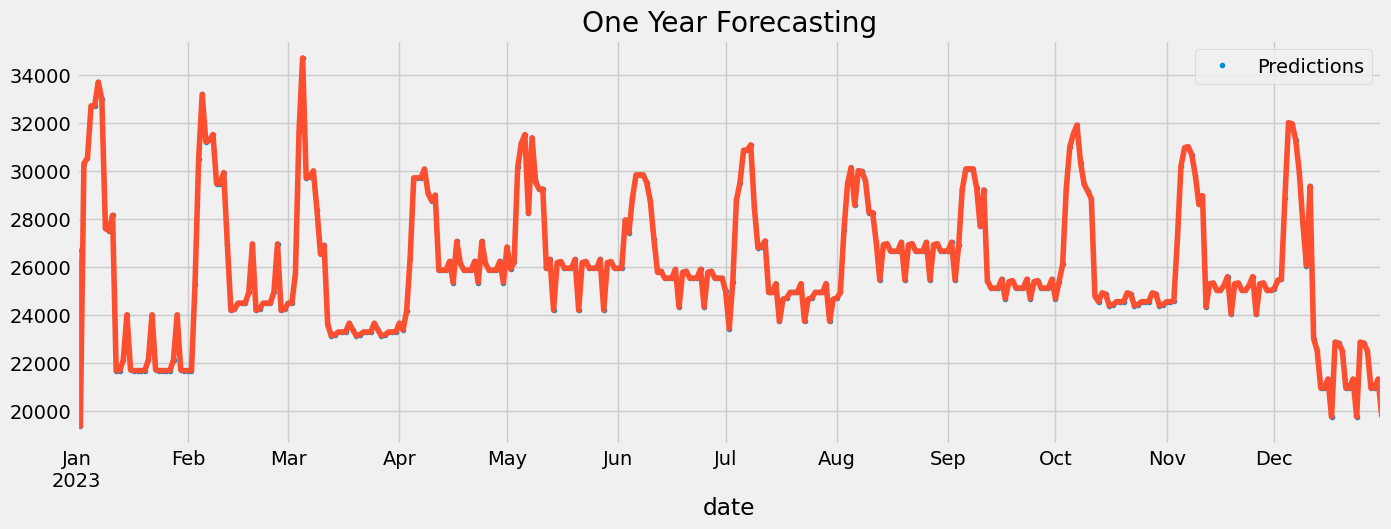

In [39]:
# One year Forecasting
to_predict = pd.DataFrame(pd.date_range(start="2023-01-01", end="2023-12-31"), columns=['date'])
to_predict.index = pd.to_datetime(to_predict.date)

to_predict_feature = create_features(to_predict)
to_predict_feature = to_predict_feature[FEATURES]

to_predict_feature['prediction'] = reg.predict(to_predict_feature)
ax = to_predict_feature['prediction'].plot(figsize=(15, 5), style='.')
to_predict_feature['prediction'].plot(ax=ax)
plt.legend(['Predictions'])
ax.set_title('One Year Forecasting')
plt.show()

In [40]:
# One Year forecasting
to_predict_feature

StatementMeta(, f8fd4b27-37cb-4707-884a-c57de3a80b96, 42, Finished, Available, Finished)

,dayofyear,dayofweek,quarter,month,year,prediction
date,,,,,,
2023-01-01,1,6,1,1,2023,26711.046875
2023-01-02,2,0,1,1,2023,19361.431641
2023-01-03,3,1,1,1,2023,30295.265625
2023-01-04,4,2,1,1,2023,30544.326172
2023-01-05,5,3,1,1,2023,32700.326172
...,...,...,...,...,...,...
2023-12-27,361,2,4,12,2023,22506.078125
2023-12-28,362,3,4,12,2023,20948.388672
2023-12-29,363,4,4,12,2023,20958.394531


#### Step 9: Store Forecasting in the Lakehouse (Delta parquet)
Storing predictions in the Lakehouse (Delta parquet) format allows for efficient and scalable storage of prediction results. 

In [41]:
# Converting pandas dataframe to pyspark dataframe
spark = SparkSession.builder.getOrCreate()
to_predict_feature = spark.createDataFrame(to_predict_feature)

StatementMeta(, f8fd4b27-37cb-4707-884a-c57de3a80b96, 43, Finished, Available, Finished)

In [ ]:
# Delta table
table_name = '#LAKEHOUSE_SILVER#.sales_forecasting_data'

to_predict_feature.write.mode("overwrite").option("overwriteSchema", "true").format("delta").saveAsTable(table_name)

StatementMeta(, f8fd4b27-37cb-4707-884a-c57de3a80b96, 44, Finished, Available, Finished)